# TFIDF基线模型 + top选最长
当前最佳得分模型

tfidf模型，主要思路是：首先计算用户的问题与问题库中的问题的相似度并选出top15的相似问题，然后去问题库对应的答案库中找出这15个问题对应的答案， 以此作为回答用户问题的候选答案。代码参考：https://github.com/WenDesi/sentenceSimilarity 运行于python3.6环境下。

用TFIDF方法做检索，其基本过程如下：
假设输入查询为query，query中包含n个词语，分别是q1、q2、…、qn；语料库为D，包含若干个句子。

step 1. 对语料库D中的所有句子进行分词；

step 2. 构建bag-of-word模型，给每个词一个id；

step 3. 计算语料库D中所有词的tfidf值；

step 4. 计算语料库D中所有句子的tfidf向量表达；

对于任一句子，其tfidf向量表达是句子中所有词的tfidf值构成的向量，保留词的先后顺序。
step 5. 对query分词，生成tfidf向量表达，计算该向量与语料库D中所有句子向量的相似度，选取top N作为检索结果。

基于TFIDF检索式方案，生成结果的方式默认是直接选择最相似的对话的A作为结果输出，这样做的问题是选择范围过于狭小。事实上，根据我们的观察，相似性top10的对话其实都比较接近，难以评判哪一个是最相似，因此，我们认为在top10相似对话的所有A中产生结果更为合理。

随之而来的问题是，如何在10个候选结果中找出最好的结果，使得deltaBleu得分最高？最开始，我们采用强化学习中的DQN方法来进行选择，直接采用bleu得分作为奖励，但是并没有带来有效的提升，甚至得分下降。针对这种情况，我们分析的结论是：DQN的目标是优化长期奖励，不适用这种仅有一个回合的场景。使用强化学习的方案遇挫，我们不得不重新回到数据上寻找答案。**在逐个观察了约100个用户与客服的完整对话记录之后，我们发现，客服的回复通常倾向于比用户说的话更长，这个现象带来的启发是：在10个候选答案中选择最长的。**经测试，top10选最长的方案，大幅提升了deltaBleu评测得分，甚至一度冲上初赛排行榜第2名。

In [1]:
# coding=utf-8
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
# import sklearn


data_chat = pd.read_csv("../data/JDDC_100W训练数据集/训练数据集/chat_5per.txt", sep = "\t", engine="python", 
                        warn_bad_lines = True, error_bad_lines = False, encoding = "UTF-8", header = None)

n_row = data_chat.shape[0]
print(n_row)

666704


## 结巴分词，创建语料库
	这里做的工作很简单，就是将所有句子分句储存在texts中，text是一个list list对象

## 根据语料库，创建词典

In [28]:
import jieba
import time
from gensim import corpora, models, similarities

time_start=time.time()

texts = []
for i in range(n_row):
    sentence = data_chat.iat[i, 6]
    list_word = list(jieba.cut(sentence))
    texts.append(list_word)
dictionary = corpora.Dictionary(texts)
corpus_simple = [dictionary.doc2bow(text) for text in texts]
print(corpus_simple[0])

time_end=time.time()
print('time cost',time_end-time_start,'s')

[(0, 1)]
time cost 57.535338401794434 s


## 计算tfidf

In [29]:
time_start=time.time()

tfidf = models.TfidfModel(corpus_simple)
corpus_tfidf = tfidf[corpus_simple]
# print(len(corpus[0]))
# print(corpus[0])
# print(len(corpus[1]))
# print(corpus[1])
# print(len(corpus[2]))
# print(corpus[2])

time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 1.1690797805786133 s


## 计算相似度矩阵

In [30]:
time_start=time.time()

# index = similarities.MatrixSimilarity(corpus)
index = similarities.Similarity("../out/", corpus_tfidf, len(dictionary))


# with open("../data/JDDC_100W训练数据集/训练数据集/corpus_simple.pkl", 'w') as f:
#     pickle.dump([dictionary, corpus_simple], f)
# tfidf.save("../data/JDDC_100W训练数据集/训练数据集/tfidf.model")
# index.save("../data/JDDC_100W训练数据集/训练数据集/index.index")


time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 103.05556917190552 s


## 句子相似度

In [31]:
# from .utils import Sentence

## 先使用sentence2vec将需要匹配的句子传进去
def sentence2vec(sentence):
    list_word = list(jieba.cut(sentence))
    vec_bow = dictionary.doc2bow(list_word)
    return tfidf[vec_bow]

def similarity(sentence, top=30):
    """求最相似的句子"""
    sentence_vec = sentence2vec(sentence)
    sims = index[sentence_vec]

    # 按相似度降序排序
    sim_sort = sorted(list(enumerate(sims)), key=lambda item: item[1], reverse=True)
    top_k = sim_sort[0:top]

    return top_k

In [32]:
result = similarity("店铺劵都有啥")
print(result)
for answer in result:
    print(data_chat.iat[answer[0]+1, 6])

[(218187, 0.59509856), (542883, 0.5943369), (17651, 0.5550804), (39164, 0.52501005), (59835, 0.52501005), (264743, 0.52501005), (309591, 0.52501005), (339316, 0.52501005), (356899, 0.52501005), (372449, 0.52501005), (481513, 0.52501005), (533146, 0.52501005), (555419, 0.52501005), (558125, 0.52501005), (588413, 0.52501005), (592525, 0.52501005), (593547, 0.52501005), (650065, 0.52501005), (29916, 0.5058065), (52324, 0.5058065), (70371, 0.5058065), (141774, 0.5058065), (198400, 0.5058065), (355376, 0.5058065), (370028, 0.5058065), (374732, 0.5058065), (414082, 0.5058065), (462072, 0.5058065), (481839, 0.5058065), (507319, 0.5058065)]
但是优惠券如果不在有效期内的话，会直接作废的
什么原因
γ元京券
ααα
差价呢
您没有申请售后呢
是正常安排送货的 非常抱歉α
您已经取消了哦
现在商品京 东 价 ￥ζ
那这边把您尝试反馈一下呢
γ 小米 红米NoteγA 全网通版 γGB+γ2GB 铂银灰 移动联通电信γG手机 双卡双待
你看不到单号???
您是什么时候换手机号码的
现在就是等配送回应的状态了
好奇你长什么样子
我之前解释的不对，抱歉
现在商品的金额是γ，您购买的时候是γ哦
服务器的问题
请问您是咨询之前的问题还是有其他的问题需要处理呢?
可以给您办理退货的呢亲爱的
亲爱的客户 这个 不是上门提货吗 您去 实体店看下 能不能
您已经申请取消订单了呢
麻烦您耐心等待一下，给您带来不便，还请您见谅~ 是的哦 应该很快的哦 正常下午就可以查看的

## 余弦相似度函数

In [25]:
import jieba

def get_word_vector(s1,s2):
    """
    :param s1: 句子1
    :param s2: 句子2
    :return: 返回句子的余弦相似度
    """
    # 分词
    cut1 = jieba.cut(s1)
    cut2 = jieba.cut(s2)
    list_word1 = (','.join(cut1)).split(',')
    list_word2 = (','.join(cut2)).split(',')

    # 列出所有的词,取并集
    key_word = list(set(list_word1 + list_word2))
    # 给定形状和类型的用0填充的矩阵存储向量
    word_vector1 = np.zeros(len(key_word))
    word_vector2 = np.zeros(len(key_word))

    # 计算词频
    # 依次确定向量的每个位置的值
    for i in range(len(key_word)):
        # 遍历key_word中每个词在句子中的出现次数
        for j in range(len(list_word1)):
            if key_word[i] == list_word1[j]:
                word_vector1[i] += 1
        for k in range(len(list_word2)):
            if key_word[i] == list_word2[k]:
                word_vector2[i] += 1

    # 输出向量
#     print(word_vector1)
#     print(word_vector2)
    return word_vector1, word_vector2

def cos_dist(s1, s2):
    """
    :param vec1: 向量1
    :param vec2: 向量2
    :return: 返回两个向量的余弦相似度
    """
    vec1, vec2 = get_word_vector(s1, s2)
    dist1= float(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
    return dist1

print(cos_dist("我喜欢", "我也喜欢"))

0.8164965809277259


In [26]:
print(data_chat.iat[result[0][0]+1, 6])
print(cos_dist(data_chat.iat[result[0][0]+1, 6], data_chat.iat[result[1][0]+1, 6]))


x_sim = np.zeros((len(result), len(result)))
for i in range(len(result)):
    for j in range(len(result)):
        if i != j:
            x_sim[i][j] = cos_dist(data_chat.iat[result[i][0]+1, 6], data_chat.iat[result[j][0]+1, 6]);
#             print("i j: " + str(i) + " " + str(j) + " " + str(cos_dist(data_chat.iat[result[i][0]+1, 6], data_chat.iat[result[j][0]+1, 6])))

print(x_sim)

但是优惠券如果不在有效期内的话，会直接作废的
0.0
[[0.         0.         0.         0.         0.12403473 0.
  0.1672484  0.         0.0438529  0.         0.         0.
  0.1869894  0.         0.         0.09245003 0.         0.2802851
  0.         0.         0.05547002 0.         0.09805807 0.1132277
  0.09805807 0.         0.         0.         0.13867505 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.      

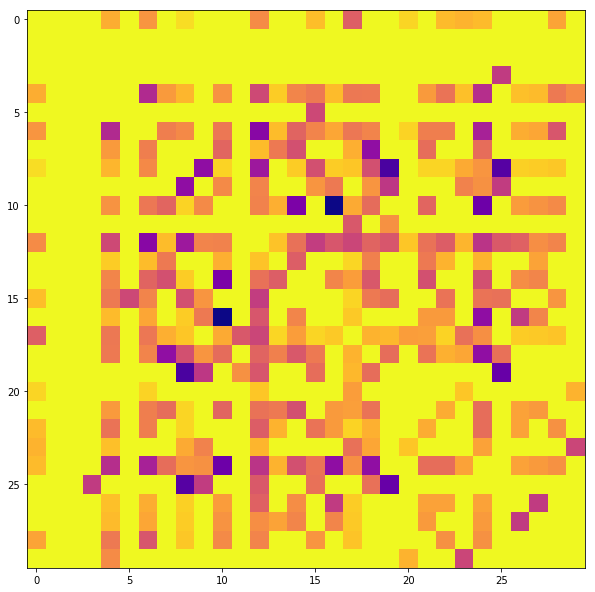

In [27]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots(figsize=(10,20))
im=ax.imshow(x_sim,cmap='plasma_r')
plt.show()

## result
我们从top15中选取result的方式是选取和其他句子相似度和最大的。  
从heatmap可以看出，13th句子和其他句子有最大相似度，其内容非常匹配Q。

In [15]:
x_sum = np.zeros((len(result,)))
for i in range(len(result)):
    x_sum[i] = x_sim[i].sum()
n_result = np.argmax(x_sum)
print(n_result, data_chat.iat[result[n_result][0]+1, 6])

8 是正常安排送货的 非常抱歉α
